# Part 1

### import some libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import signal
import pickle
from scipy.linalg import toeplitz
import os, sys, gc
from PIL import Image
from skimage.transform import resize #resize mnist images
import scipy
import time
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from skimage.metrics import structural_similarity as ssim
try:
    from skimage.restoration import denoise_tv_chambolle
except ImportError:
    from skimage.filters import denoise_tv_chambolle
from skimage.metrics import structural_similarity




# Part 2
### PSF design parameters:

WAVELENGTH : lambda

GRID_NUM_PIXELS_X  : This is the size of the entire window in pixels

GRID_NUM_PIXELS_Y  : This is the size of the entire window in pixels

GRID_PIXEL_SIZE : pixel size

sample_to_sensor_distance  : distance from phase mask to detector

### GS alogorithm functions to design phase mask:

def GSalgo(target_E,knum=10): target_E is the sqrt of iPSF we want , knum is the number of iteration

In [2]:
WAVELENGTH = 633.e-9
GRID_NUM_PIXELS_X = 15 # This is the size of the entire window in pixels
GRID_NUM_PIXELS_Y = 15
GRID_PIXEL_SIZE = 0.35e-6*160

sample_to_sensor_distance = 4.e-3

GRID_INFO = [GRID_NUM_PIXELS_X,
             GRID_NUM_PIXELS_Y,
             GRID_PIXEL_SIZE]

def get_mesh(grid_info):

    grid_num_steps_x, grid_num_steps_y, grid_pixel_size = grid_info

    x = np.arange(-grid_num_steps_x/2, grid_num_steps_x/2) * grid_pixel_size
    y = np.arange(-grid_num_steps_y/2, grid_num_steps_y/2) * grid_pixel_size
    xx, yy = np.meshgrid(x,y)

    fx = np.fft.fftfreq(grid_num_steps_x, d=grid_pixel_size)
    fy = np.fft.fftfreq(grid_num_steps_y, d=grid_pixel_size)
    fxx, fyy = np.meshgrid(fx, fy)

    return xx, yy, fxx, fyy

XX, YY, FXX, FYY = get_mesh(GRID_INFO)
FZZ_VAC = np.sqrt( (1/WAVELENGTH)**2 - FXX**2 - FYY**2 + 0.j )
H_vac = np.exp(1.j * 2.*np.pi * (FZZ_VAC*sample_to_sensor_distance))
H_vac_tf = tf.convert_to_tensor(H_vac, dtype=tf.complex64)

H_mod=(np.abs(H_vac_tf)>0.01)*H_vac_tf+(np.abs(H_vac_tf)<0.01)*np.ones(shape=(GRID_NUM_PIXELS_X,GRID_NUM_PIXELS_Y))

XX1, YY1, FXX1, FYY1 = get_mesh([2400,2400,0.35e-6])
FZZ_VAC1 = np.sqrt( (1/WAVELENGTH)**2 - FXX1**2 - FYY1**2 + 0.j )
H_vac_2400 = np.exp(1.j * 2.*np.pi * (FZZ_VAC1*sample_to_sensor_distance))
H_vac_tf_2400 = tf.convert_to_tensor(H_vac_2400, dtype=tf.complex64)

#For GS algorithm
def forward(x,phi):
    mask = np.exp(1.j*phi)
    out = x*mask   
    out = np.fft.fft2(out)
    out = out * H_mod
    out = np.fft.ifft2(out)
    return out
def backward(out,phi):
    mask = np.exp(1.j*phi)
    bac=out*mask
    bac=np.fft.fft2(bac)
    bac=bac/H_mod
    bac=np.fft.ifft2(bac)
    return bac
def forward_real(x,phi):
    mask = np.exp(1.j*phi)
    out = x*mask   
    out = np.fft.fft2(out)
    out = out * H_vac_tf
    out = np.fft.ifft2(out)
    return out
def forward_2400(x,phi):
    mask = np.exp(1.j*phi)
    out = x*mask   
    out = np.fft.fft2(out)
    out = out * H_vac_tf_2400
    out = np.fft.ifft2(out)
    return out
def GSalgo(target_E,knum=10):
    input_E=np.ones(shape=(GRID_NUM_PIXELS_X,GRID_NUM_PIXELS_Y))
    input_E=input_E*np.sqrt(100/np.sum(input_E**2))
    target_E=target_E*np.sqrt(100/np.sum(target_E**2))
    print(np.sum(input_E**2),np.sum(target_E**2))
    phi0=np.random.uniform(low=-np.pi,high=np.pi,size=input_E.shape)
    outplain=forward(input_E,phi0)
    for k in range(knum):
        outplain_phi=np.angle(outplain)
        inplain=backward(target_E,outplain_phi)
        inplain_phi=np.angle(inplain)
        outplain=forward(input_E,inplain_phi)
        print(k)
    plt.figure(figsize=(15,9))
    plt.subplot(131)
    plt.imshow(np.abs(outplain))
    plt.title('designed PSF amplitude')
    plt.colorbar()
    plt.subplot(132)
    plt.imshow(target_E)
    plt.title('wanted PSF amplitude')
    plt.colorbar()
    plt.subplot(133)
    plt.imshow(target_E-np.abs(outplain))
    plt.title('the error betweent them')
    plt.colorbar()
    return inplain_phi,np.abs(outplain)


# Part 3

### functions to convert the convolution to matrix multiplication

#### mainly used are:(just go ahead)

def get_doubly_blocked(I, F, print_ir=False):

def from_convmatrix_to_A(doubly_blocked,shape,cropped_shape):

def samplein(ker_mulchunk,croppedshape,m1,m2,n1,n2):

### functions for TV optimization algorithm:

#### mainly used are:(just go ahead)

def A_SPI_R_TV(A,imgshape, measurements, para=None):

In [3]:
def _centered(arr, newshape):
    # Return the center newshape portion of the array.
    currshape = tf.shape(arr)[-2:]
    startind = (currshape - newshape) // 2
    endind = startind + newshape
    return arr[..., startind[0]:endind[0], startind[1]:endind[1]]
def conv2d_fft(in1, in2, mode="same"):
#convolution with fft

    # Extract shapes
    s1 = np.array(in1.shape)
    s2 = np.array(in2.shape)
    shape = s1 + s2 - 1

    # Compute convolution in fourier space
    sp1 = np.fft.rfft2(in1, shape)
    sp2 = np.fft.rfft2(in2, shape)
    ret = np.fft.irfft2(sp1 * sp2, shape)
    #ret = np.fft.fftshift(ret)

    # Crop according to mode
    if mode == "full":
        cropped = ret
    elif mode == "same":
        cropped = _centered(ret, s1)
    elif mode == "valid":
        cropped = _centered(ret, s1 - s2 + 1)
    else:
        raise ValueError("Acceptable mode flags are 'valid',"
                         " 'same', or 'full'.")

    # Reorder channels to last

    return cropped

##################################################
#turn convolution to matrix multiply,get the transfer matrix

def matrix_to_vector(input):

    input_h, input_w = input.shape
    output_vector = np.zeros(input_h*input_w, dtype=input.dtype)
    # flip the input matrix up-down because last row should go first
    input = np.flipud(input) 
    for i,row in enumerate(input):
        st = i*input_w
        nd = st + input_w
        output_vector[st:nd] = row
        
    return output_vector


def vector_to_matrix(input, output_shape):
    
    output_h, output_w = output_shape
    output = np.zeros(output_shape, dtype=input.dtype)
    for i in range(output_h):
        st = i*output_w
        nd = st + output_w
        output[i, :] = input[st:nd]
    # flip the output matrix up-down to get correct result
    output=np.flipud(output)
    return output

def get_doubly_blocked(I, F, print_ir=False):
    
    # number of columns and rows of the input 
    I_row_num, I_col_num = I.shape 

    # number of columns and rows of the filter
    F_row_num, F_col_num = F.shape

    #  calculate the output dimensions
    output_row_num = I_row_num + F_row_num - 1
    output_col_num = I_col_num + F_col_num - 1
    if print_ir: print('output dimension:', output_row_num, output_col_num)

    # zero pad the filter
    F_zero_padded = np.pad(F, ((output_row_num - F_row_num, 0),
                               (0, output_col_num - F_col_num)),
                            'constant', constant_values=0)
    if print_ir: print('F_zero_padded: ', F_zero_padded)

    # use each row of the zero-padded F to creat a toeplitz matrix. 
    #  Number of columns in this matrices are same as numbe of columns of input signal
    toeplitz_list = []
    for i in range(F_zero_padded.shape[0]-1, -1, -1): # iterate from last row to the first row
        c = F_zero_padded[i, :] # i th row of the F 
        r = np.r_[c[0], np.zeros(I_col_num-1)] # first row for the toeplitz fuction should be defined otherwise
                                                            # the result is wrong
        toeplitz_m = toeplitz(c,r) # this function is in scipy.linalg library
        toeplitz_list.append(toeplitz_m)
        if print_ir: print('F '+ str(i)+'\n', toeplitz_m)

        # doubly blocked toeplitz indices: 
    #  this matrix defines which toeplitz matrix from toeplitz_list goes to which part of the doubly blocked
    c = range(1, F_zero_padded.shape[0]+1)
    r = np.r_[c[0], np.zeros(I_row_num-1, dtype=int)]
    doubly_indices = toeplitz(c, r)
    if print_ir: print('doubly indices \n', doubly_indices)

    ## creat doubly blocked matrix with zero values
    toeplitz_shape = toeplitz_list[0].shape # shape of one toeplitz matrix
    h = toeplitz_shape[0]*doubly_indices.shape[0]
    w = toeplitz_shape[1]*doubly_indices.shape[1]
    doubly_blocked_shape = [h, w]
    doubly_blocked = np.zeros(doubly_blocked_shape)

    # tile toeplitz matrices for each row in the doubly blocked matrix
    b_h, b_w = toeplitz_shape # hight and withs of each block
    for i in range(doubly_indices.shape[0]):
        for j in range(doubly_indices.shape[1]):
            start_i = i * b_h
            start_j = j * b_w
            end_i = start_i + b_h
            end_j = start_j + b_w
            doubly_blocked[start_i: end_i, start_j:end_j] = toeplitz_list[doubly_indices[i,j]-1]

    if print_ir: print('doubly_blocked: ', doubly_blocked)
    return doubly_blocked
######get the transfer matrix(between the input and the binded output),because the output is the value sumed in a chunk
def chunksum(A,rownum,colnum):
    m=len(A)
    n=len(A[0])
    deltarow=int(m/rownum)
    deltacol=int(n/colnum)
    out=np.zeros((rownum,colnum))
    for i in range(rownum):
        for j in range(colnum):
            out[i,j]=np.sum(A[i*deltarow:(i+1)*deltarow,j*deltacol:(j+1)*deltacol])
    return out
def from_convmatrix_to_A(doubly_blocked,shape,cropped_shape):
    m=shape[0]
    n=shape[1]
    mprime=cropped_shape[0]
    nprime=cropped_shape[1]
    q=np.arange(0,m*n)

    w=vector_to_matrix(q,(m,n))
    deltarow=int(m/mprime)
    deltacol=int(n/nprime)
    Aout=np.zeros((mprime*nprime,len(doubly_blocked[0])))
    k=0
    transfermatrix=np.zeros((mprime*nprime,m*n))
    
    for i in range(mprime):
        for j in range(nprime):
            imod=mprime-1-i
            mat=w[imod*deltarow:(imod+1)*deltarow,j*deltacol:(j+1)*deltacol]
            for indes in mat.flatten():
                Aout[k]=Aout[k]+doubly_blocked[indes]
                transfermatrix[k,indes]=1
            k+=1
    return Aout,transfermatrix
########get the transfer matrix(between the input and the samples),samples are selected from the center of the summed chunks
########It's the final transfer matrix we use
def samplein(ker_mulchunk,croppedshape,m1,m2,n1,n2):
    w=np.arange(0,croppedshape[0]*croppedshape[1])
    w=vector_to_matrix(w,croppedshape)
    qw=w[m1:m2,n1:n2]
    qw=matrix_to_vector(qw)
    out=np.zeros(shape=(len(qw),len(ker_mulchunk[0])))
    for i in range(len(qw)):
        out[i]=ker_mulchunk[qw[i]].copy()
    return out


#############Belows are the TV alogrithms we use,u can just go ahead and see them later
def generate_H(N1,N2,gradient_order=None):
    # generate gradient operator matrix
    if gradient_order!=None:
        go=gradient_order;
    else:
        go=2; #% default


    h1=np.array([-1,1]);
    h2=np.array([-1,1]);

    # H1
    H1=np.zeros((N1*(N2-1),N1*N2));
    for xx in range(1,N1+1):
        for yy in range(1,N2):
            H1[xx+(yy-1)*N1-1,xx+(yy-1)*N1-1]=h1[0];
            H1[xx+(yy-1)*N1-1,xx+yy*N1-1]=h1[1];

    #H1=sparse(H1);

    # H2
    H2=np.zeros(((N1-1)*N2,N1*N2));
    for xx in range(1,N1):
        for yy in range(1,N2+1):
            H2[xx+(yy-1)*(N1-1)-1,xx+(yy-1)*N1-1]=h2[0];
            H2[xx+(yy-1)*(N1-1)-1,xx+1+(yy-1)*N1-1]=h2[1];

        #H2=sparse(H2);
        H=np.concatenate((H1,H2),axis=0);

    if go==2:
        h3=np.array([1,-2,1]);
        h4=np.array([1,-2,1]);
        h5=np.array([-1,1,1,-1]);
        #% H3
        H3=np.zeros((N1*(N2-2),N1*N2));
        for x in range(1,N1+1):
            for y in range(1,N2-1):
                H3[x+(y-1)*N1-1,x+(y-1)*N1-1]=h3[0];
                H3[x+(y-1)*N1-1,x+y*N1-1]=h3[1];
                H3[x+(y-1)*N1-1,x+(y+1)*N1-1]=h3[2];

#    H3=sparse(H3);

#    % H4
        H4=np.zeros(((N1-2)*N2,N1*N2));
        for x in range(1,N1-1):
            for y in range(1,N2+1):
                H4[x+(y-1)*(N1-2)-1,x+(y-1)*N1-1]=h4[0];
                H4[x+(y-1)*(N1-2)-1,x+1+(y-1)*N1-1]=h4[1];
                H4[x+(y-1)*(N1-2)-1,x+2+(y-1)*N1-1]=h4[2];

    #    H4=sparse(H4);

    #    % H5
        H5=np.zeros(((N1-1)*(N2-1),N1*N2));
        for x in range(1,N1):
            for y in range(1,N2):
                H5[x+(y-1)*(N1-1)-1,x+(y-1)*N1-1]=h5[0];
                H5[x+(y-1)*(N1-1)-1,x+1+(y-1)*N1-1]=h5[1];
                H5[x+(y-1)*(N1-1)-1,x+y*N1-1]=h5[2];
                H5[x+(y-1)*(N1-1)-1,x+1+y*N1-1]=h5[3];

    #    H5=sparse(H5);

        H=np.concatenate((H,H3,H4,H5),axis=0)
    
    return H


# subfunction m_tv
def m_tv(H,P,y,x0,mu_0,rho,tol,min_iter,plot_flag=0):
# solve the following model using the Lagrange multiplier method
# min ||Hx||_1
# s.t.Px=y;

    x=x0.copy();
    w=H.dot(x);
    r=np.zeros_like(w);
    s=np.zeros_like(y);
    object_kp=np.linalg.norm(P.dot(x)-y);
    o=object_kp;
    mu=mu_0;
    mu_bar=mu_0;
    converged=False;
    Iter=0;
    max_iter=300;

    #% % pinv_mat=pinv(H'*H+P'*P);

    #% speed up (by Liheng, 2016-06-01)
    temp = H.T.dot(H)+P.T.dot(P);
    pinv_mat=np.linalg.inv(temp).dot(np.eye(len(temp)));
    pinv_matH = pinv_mat.dot(H.T);
    pinv_matP = pinv_mat.dot(P.T);


    while (converged==False) and (Iter<=max_iter):
        Iter=Iter+1;

        #% update w
        tmp=H.dot(x)-1/mu*r;
        flag1=tmp>1/mu;
        flag2=tmp<-1/mu;
        w=(tmp-1/mu)*flag1+(tmp+1/mu)*flag2;

        #% update x
        x = pinv_matH.dot(w+1/mu*r) + pinv_matP.dot(y-1/mu*s);

        #% update r & s
        r=r+mu*(w-H.dot(x)); 
        s=s+mu*(P.dot(x)-y);

        #% update mu
        mu=min(mu_bar,mu*rho);   

        #% stop criterion
        object_k=object_kp;
        object_kp=np.linalg.norm(P.dot(x)-y);
        stop_c1=object_k-object_kp;    
        if (stop_c1<tol and stop_c1>=0) and Iter>min_iter:
            converged=True;
    #% %         disp('iteration is converged');
        elif Iter>max_iter:
            converged=True;
    #% %         disp('iter number reached maximun number');


        if Iter%10 == 0:
            print(f'TV iteration {Iter}, the error is {stop_c1}\n');

    totaliter = Iter;
    print(f'TV total iterations {totaliter}, the error is {(stop_c1)} \n');
    return x,totaliter


def fun_SPI_R_TV(patterns, measurements, para=None):
    row, col, m = patterns.shape;
    P = np.reshape(patterns, [row*col, m]);
    P = P.T; #% each row represents a pattern

    gradient_order = 1;

    mu_0 = 1e-3;
    rho = 1.05;
    plot_flag=0;
#    tol=1e-2; #% accuracy
    tol=1e-5
    min_iter = 30;
    x0 = np.ones((row * col,1));
    if para!=None:
        tol = para.tol; #% accuracy
        min_iter = para.min_iter;
        x0 = para.x0;
        mu_0 = para.mu;
    #% CS reconstruction
    H = generate_H(row,col,gradient_order);
    x_tv, totaliter=m_tv(H,P,measurements,x0,mu_0,rho,tol,min_iter,plot_flag);
    im_r = np.reshape(x_tv,[row,col]);
    return im_r, totaliter

def A_SPI_R_TV(A,imgshape, measurements, para=None):
    m = len(measurements);
    row,col=imgshape

    P=A.copy()
    
    gradient_order = 1;
    mu_0 = 1e-3;
    rho = 1.05;
    plot_flag=0;

    tol=1e-2; #% accuracy
    min_iter = 30;
    x0 = np.ones((row * col,1));
    if para!=None:
        tol = para.tol; #% accuracy
        min_iter = para.min_iter;
        x0 = para.x0;
        mu_0 = para.mu;
    #% CS reconstruction
    H = generate_H(row,col,gradient_order);
    x_tv, totaliter=m_tv(H,P,measurements,x0,mu_0,rho,tol,min_iter,plot_flag);
#    im_r = np.reshape(x_tv,[row,col]);
    return x_tv, totaliter

def expandmatrix(a,row,col):
    rowa=len(a)
    cola=len(a[0])
    deltarow=int(row/rowa)
    deltacol=int(col/cola)
    out=np.zeros(shape=(row,col))
    for i in range(rowa):
        for j in range(cola):
            out[i*deltarow:(i+1)*deltarow,j*deltacol:(j+1)*deltacol]=np.ones(shape=(deltarow,deltacol))*a[i,j]
    return out

# Part 4 
###  Using one image to see the result
#### First take one image

#### second randomly initialize a PSF

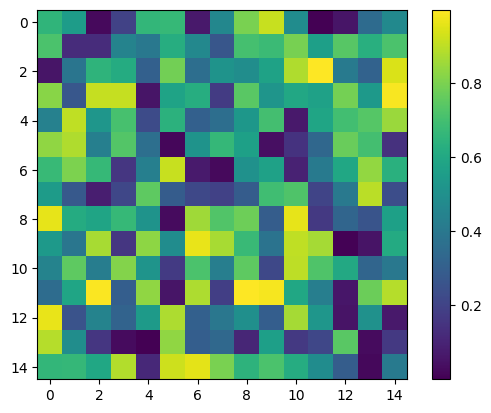

In [4]:
PSFshape=np.array([GRID_NUM_PIXELS_X,GRID_NUM_PIXELS_Y])
PSF=np.random.uniform(size=PSFshape)
plt.imshow(PSF)
plt.colorbar()

#### thirdly design the real PSF as PSFmod

100.00000000000003 99.99999999999999
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


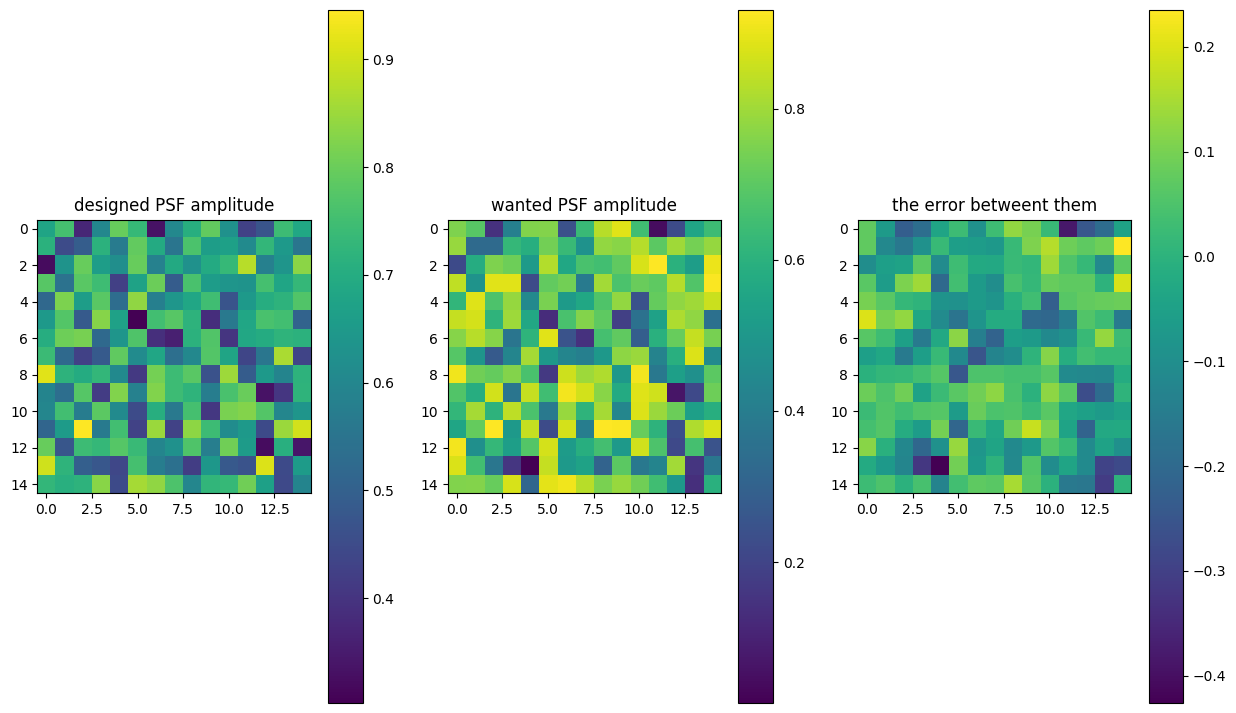

In [5]:
phasemask,PSFmod=GSalgo(np.sqrt(PSF),knum=60)

In [6]:
phasemask=np.loadtxt('D:/models/designedphase_15_1.txt')
PSFmod=forward(np.ones_like(phasemask),phasemask)
PSFmod=np.abs(PSFmod)**2

In [7]:
#PSFmod=PSFmod**2

#### PSF's phase mask

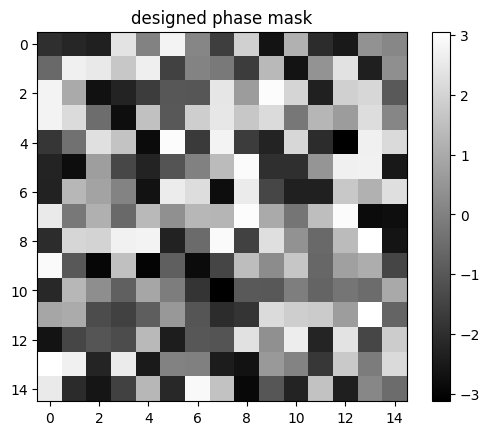

In [8]:
plt.imshow(phasemask,cmap='gray')
plt.title('designed phase mask')
plt.colorbar()

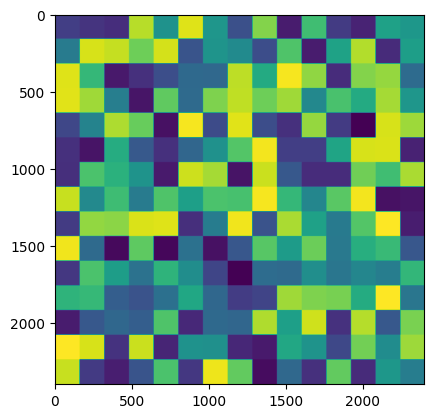

In [9]:
qwe=expandmatrix(phasemask,2400,2400)
plt.imshow(qwe)

Text(0.5, 1.0, 'bining the real PSF')

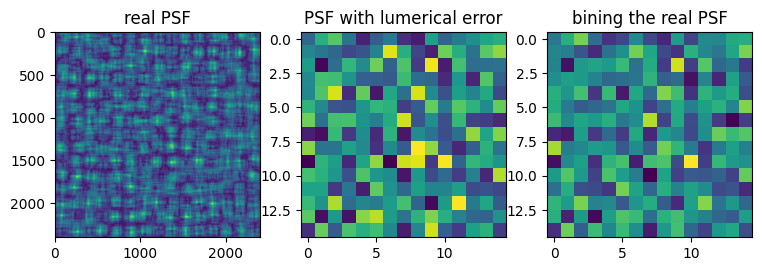

In [10]:
def bining(a,row,col):
    out=np.zeros(shape=(row,col))
    deltarow=int(len(a)/row)
    deltacol=int(len(a[0])/col)
    for i in range(row):
        for j in range(col):
            out[i,j]=np.sum(a[i*deltarow:(i+1)*deltarow,j*deltacol:(j+1)*deltacol])
    return out
plt.figure(figsize=(9,15))
error_corrected=forward_2400(np.ones_like(qwe),qwe)
plt.subplot(1,3,1)
plt.imshow(np.abs(error_corrected))
plt.title('real PSF')
plt.subplot(1,3,2)
plt.imshow(PSFmod)
plt.title('PSF with lumerical error')
plt.subplot(1,3,3)
qwert=bining(np.abs(error_corrected)**2,15,15)
plt.imshow(qwert)
plt.title('bining the real PSF')

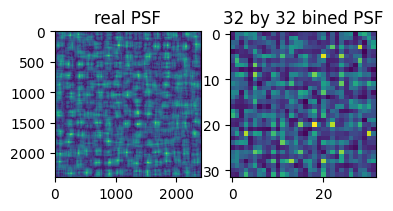

In [11]:
#fig=plt.figure()
plt.subplot(1,3,1)

plt.imshow(np.abs(error_corrected))
plt.title('real PSF')

plt.subplot(1,3,2)
PSF=np.abs(error_corrected)**2
qw=bining(PSF,32,32)
plt.imshow(qw/np.max(qw))
#plt.colorbar()
PSFmod=qw/np.max(qw)
plt.title('32 by 32 bined PSF')
plt.savefig('C:/Users/DELL/Desktop/cheat/asd.png',bbox_inches='tight',dpi=300)

In [12]:
np.savetxt('D:/models/designedphase_15_4.txt',phasemask)

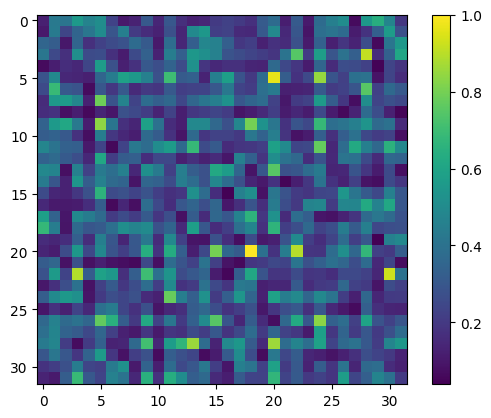

In [13]:
plt.imshow(PSFmod)
plt.colorbar()

#### Fourth to see that image's compression and reconstruction result

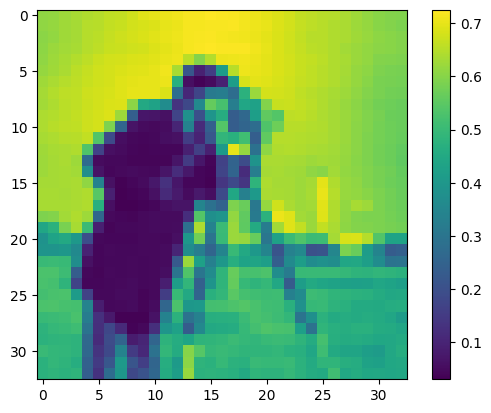

In [14]:

ww=plt.imread('C:/Users/DELL/Pictures/Camera Roll/cameraman.jpg')
qww=ww[:,:,1]
trial=qww
#trialp=np.zeros((100,100))
#trialp[25:75,25:75]=resize(trial,(50,50))

imgshape=np.array([33,33])
PSFshape=np.array([32,32])

trialp_ori=resize(trial,imgshape)
trialp=trialp_ori
plt.imshow(trialp)
plt.colorbar()


In [15]:
trialp_vec=matrix_to_vector(trialp)
ker_mul=get_doubly_blocked(trialp,PSFmod)
re=vector_to_matrix(np.matmul(ker_mul,trialp_vec),PSFshape+imgshape-1)

croppedshape=np.array([32,32])
ker_mulchunk=from_convmatrix_to_A(ker_mul,PSFshape+imgshape-1,croppedshape)[0]
rec=np.matmul(ker_mulchunk,trialp_vec)
recrop=vector_to_matrix(rec,croppedshape)

pp=samplein(ker_mulchunk,croppedshape,6,26,6,26)



#### Compressed image (ratio=0.5)

In [16]:
pp.shape

(400, 1089)

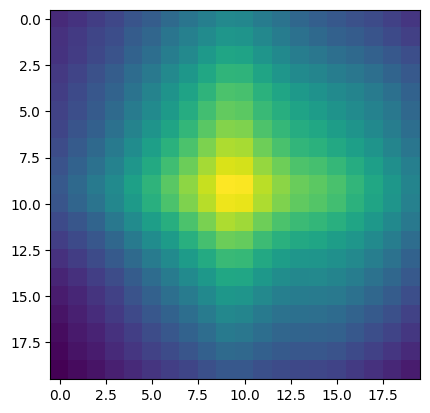

In [17]:
ccrop_vec=np.matmul(pp,trialp_vec)
ccrop=vector_to_matrix(ccrop_vec,(20,20))
plt.imshow(ccrop)

#### Reconstructed image

TV iteration 10, the error is 2.0317081350640365e-14

TV iteration 20, the error is -1.9106938253798944e-13

TV iteration 30, the error is 4.1744385725905886e-13

TV total iterations 32, the error is 1.3011813848606835e-13 



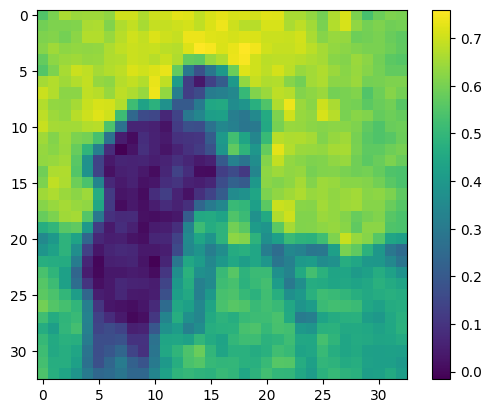

In [18]:

im_vec=np.reshape(ccrop_vec,(-1,1))

im_r_TV, totaliter = A_SPI_R_TV(pp,(33,33),im_vec);

im_r_TV=np.reshape(im_r_TV,(-1))
imag_r_TV=vector_to_matrix(im_r_TV,(33,33))

plt.imshow(imag_r_TV)
plt.colorbar()

# Part 5 
### Comparison between different compression ratios(from 0.14 to 0.5) results
### And gradually add some noise and shift

TV iteration 10, the error is 2.0039525594484076e-14

TV iteration 20, the error is -1.0486056467584604e-13

TV iteration 30, the error is -1.1554646128786317e-13

TV total iterations 31, the error is 1.5837331446277858e-13 

TV iteration 10, the error is -8.426592756904938e-14

TV iteration 20, the error is 3.481659405224491e-13

TV iteration 30, the error is -5.340172748447003e-14

TV total iterations 31, the error is 2.1965762542208722e-13 

TV iteration 10, the error is -2.51909604287448e-13

TV iteration 20, the error is 4.275468867831478e-13

TV iteration 30, the error is 1.7574830479816228e-13

TV total iterations 32, the error is 1.1984857550828565e-13 

TV iteration 10, the error is -2.1094237467877974e-14

TV iteration 20, the error is -6.816769371198461e-14

TV iteration 30, the error is 7.294165271787278e-14

TV total iterations 31, the error is 3.441691376337985e-14 

TV iteration 10, the error is -1.1834977442504169e-13

TV iteration 20, the error is -2.6711965972481266e-

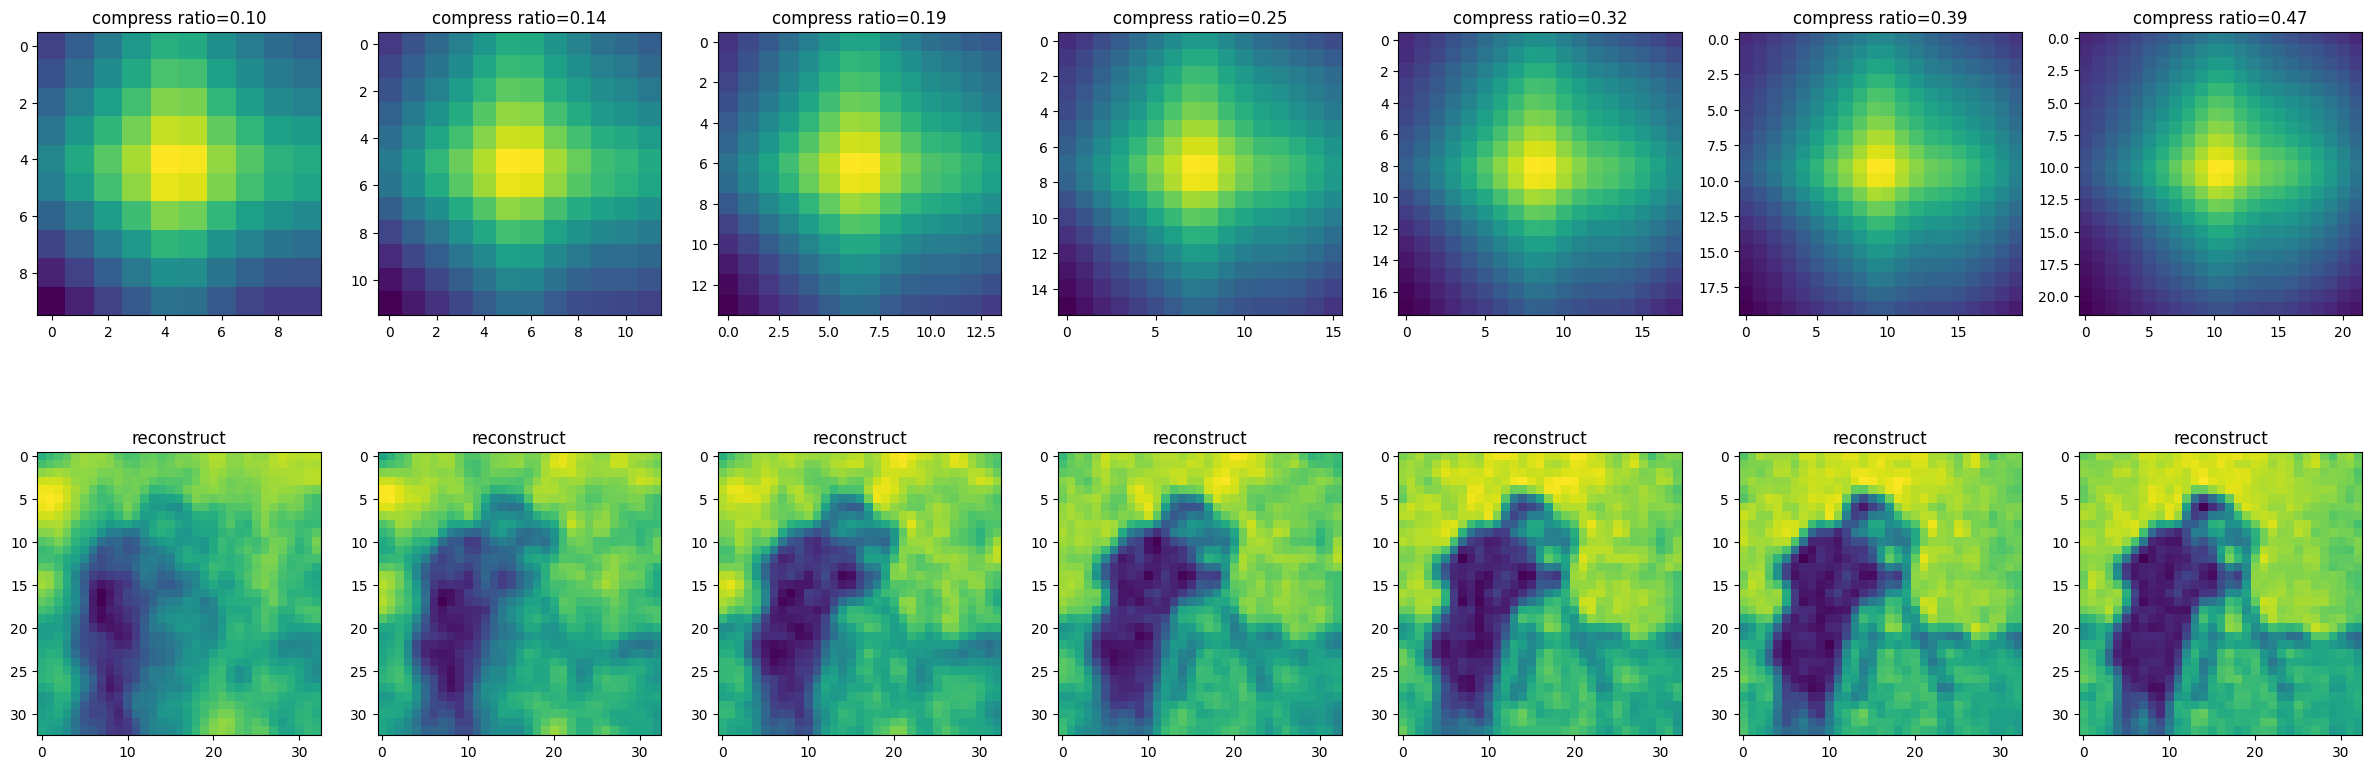

In [19]:
#trialp=x_train[1000,:,:,0]
trialp_vec=matrix_to_vector(trialp_ori)
plt.figure(figsize=(30,10))
beg=5
end=12
compressratio=[]
ssims=[]
for i in range(beg,end):
    pp=samplein(ker_mulchunk,croppedshape,16-i,16+i,16-i,16+i)
    ccrop_vec=np.matmul(pp,trialp_vec)
    ccrop=vector_to_matrix(ccrop_vec,(2*i,2*i))
    plt.subplot(2,end-beg,i-beg+1)
    plt.imshow(ccrop)
    plt.title('compress ratio={:.2f}'.format(4*i**2/1024))
    #plt.colorbar()
    compressratio.append(4*i**2/1024)
    
    im_vec=np.reshape(ccrop_vec,(-1,1))
    im_r_TV, totaliter = A_SPI_R_TV(pp,(33,33),im_vec);
    im_r_TV=np.reshape(im_r_TV,(-1))
    imag_r_TV=vector_to_matrix(im_r_TV,(33,33))
    
    plt.subplot(2,end-beg,i-beg+1+end-beg)
    plt.imshow(imag_r_TV)
    plt.title('reconstruct')
    ss=ssim(imag_r_TV,trialp_ori)
    ssims.append(ss)
    #plt.colorbar()
    
plt.savefig('C:/Users/DELL/Desktop/cheat/f.png',bbox_inches='tight',dpi=500)   

TV iteration 10, the error is -2.425837308805967e-14

TV iteration 20, the error is -2.1360690993788012e-13

TV iteration 30, the error is 2.67841304690819e-13

TV total iterations 32, the error is 1.9978463328129692e-13 

TV iteration 10, the error is -2.1788126858268697e-13

TV iteration 20, the error is 4.3626213752645526e-13

TV iteration 30, the error is -2.2476465133536294e-13

TV total iterations 31, the error is 3.0503377601576176e-13 

TV iteration 10, the error is -6.744604874597826e-14

TV iteration 20, the error is -8.154588115871775e-14

TV iteration 30, the error is -9.231504449758177e-14

TV total iterations 31, the error is 3.1402658251522553e-13 

TV iteration 10, the error is 1.1457501614131615e-13

TV iteration 20, the error is 1.1535217225855376e-13

TV iteration 30, the error is -1.936228954946273e-13

TV total iterations 32, the error is 1.5909495942878493e-13 

TV iteration 10, the error is -1.0047518372857667e-13

TV iteration 20, the error is 1.0824674490095276

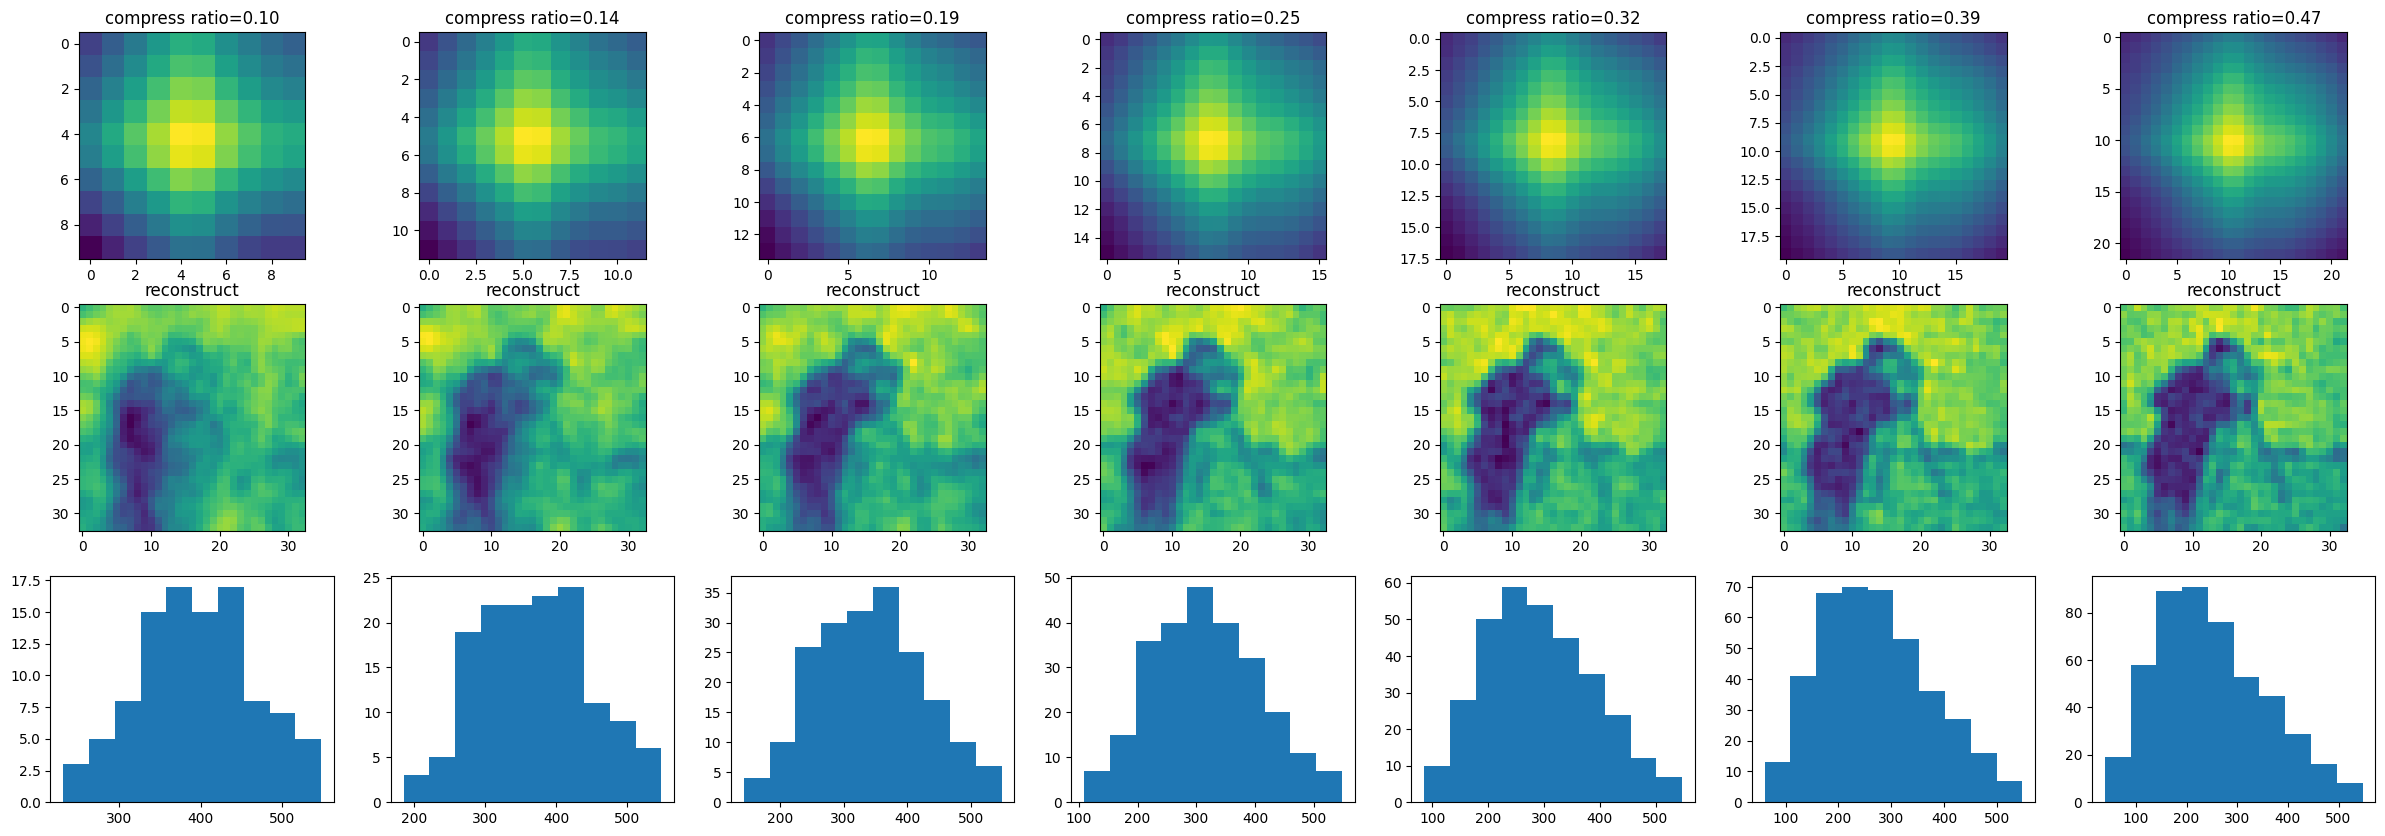

In [20]:
#trialp=x_train[1000,:,:,0]
trialp_vec=matrix_to_vector(trialp_ori)
plt.figure(figsize=(30,10))
beg=5
end=12
compressratio=[]
ssims_1=[]
for i in range(beg,end):
    pp=samplein(ker_mulchunk,croppedshape,16-i,16+i,16-i,16+i)
    ccrop_vec=np.matmul(pp,trialp_vec)
    ccrop=vector_to_matrix(ccrop_vec,(2*i,2*i))
    plt.subplot(3,end-beg,i-beg+1)
    plt.imshow(ccrop)
    plt.title('compress ratio={:.2f}'.format(4*i**2/1024))
    #plt.colorbar()
    compressratio.append(4*i**2/1024)
    
    
    ccrop_vec=ccrop_vec+0.01*ccrop_vec.std()*np.random.uniform(-0.5,0.5,size=ccrop_vec.shape)
    
    im_vec=np.reshape(ccrop_vec,(-1,1))
    im_r_TV, totaliter = A_SPI_R_TV(pp,(33,33),im_vec);
    im_r_TV=np.reshape(im_r_TV,(-1))
    imag_r_TV=vector_to_matrix(im_r_TV,(33,33))
    
    plt.subplot(3,end-beg,i-beg+1+end-beg)
    plt.imshow(imag_r_TV)
    plt.title('reconstruct')
    ss=ssim(imag_r_TV,trialp_ori)
    ssims_1.append(ss)
    
    plt.subplot(3,end-beg,i-beg+1+(end-beg)*2)
    plt.hist(ccrop_vec)
    #plt.colorbar()

TV iteration 10, the error is 2.141620214501927e-13

TV iteration 20, the error is 2.4635848916432224e-13

TV iteration 30, the error is -1.0683121054455569e-13

TV total iterations 32, the error is 2.7566837701442637e-13 

TV iteration 10, the error is 1.4971357487070236e-13

TV iteration 20, the error is 2.549627176051672e-13

TV iteration 30, the error is 7.982503547054876e-14

TV total iterations 32, the error is 1.9462209621678994e-13 

TV iteration 10, the error is -3.0142555118573e-14

TV iteration 20, the error is -5.745404152435185e-14

TV iteration 30, the error is 3.4466873799487985e-13

TV total iterations 33, the error is 8.298917109073045e-14 

TV iteration 10, the error is -1.170175067954915e-13

TV iteration 20, the error is 6.8833827526759706e-15

TV iteration 30, the error is 7.849276784099857e-14

TV total iterations 32, the error is 1.4155343563970746e-13 

TV iteration 10, the error is -7.30526750203353e-14

TV iteration 20, the error is 1.5765166949677223e-14

TV 

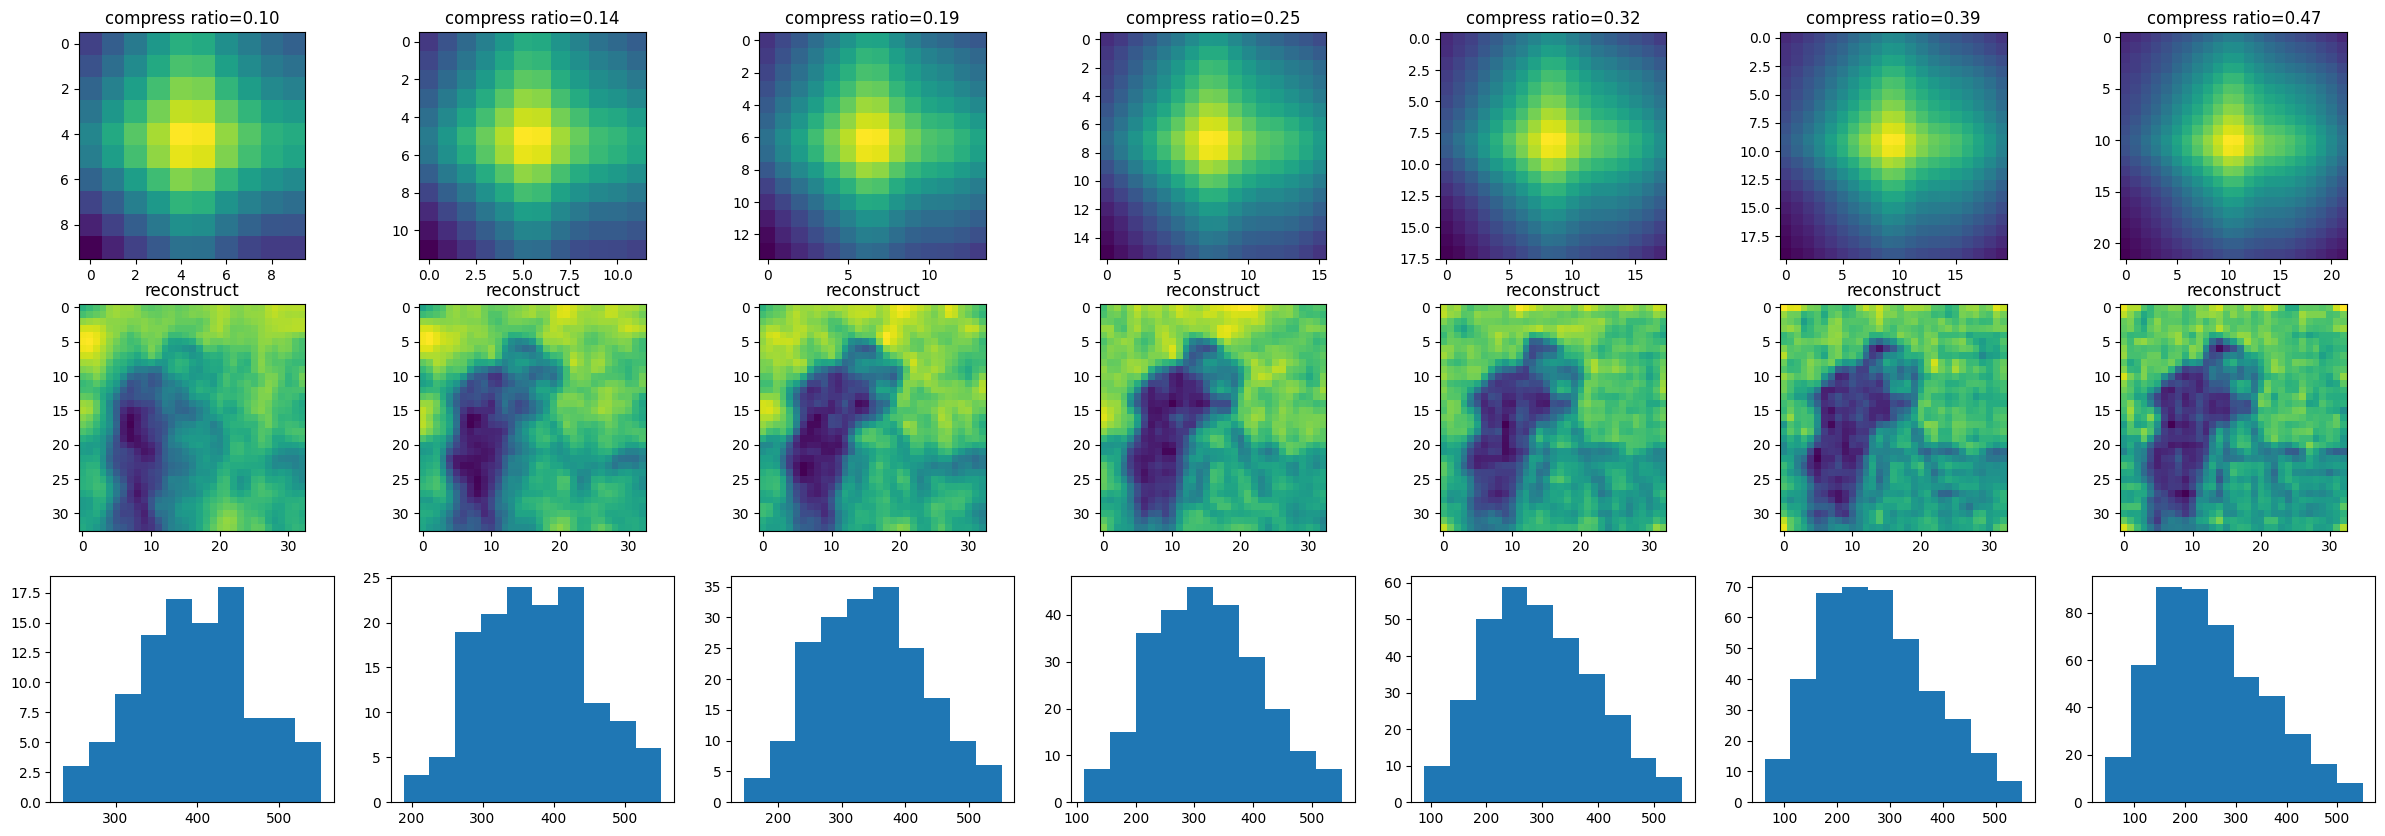

In [21]:
trialp_vec=matrix_to_vector(trialp_ori)
plt.figure(figsize=(30,10))
beg=5
end=12
compressratio=[]
ssims_3=[]
for i in range(beg,end):
    pp=samplein(ker_mulchunk,croppedshape,16-i,16+i,16-i,16+i)
    ccrop_vec=np.matmul(pp,trialp_vec)
    ccrop=vector_to_matrix(ccrop_vec,(2*i,2*i))
    plt.subplot(3,end-beg,i-beg+1)
    plt.imshow(ccrop)
    plt.title('compress ratio={:.2f}'.format(4*i**2/1024))
    #plt.colorbar()
    compressratio.append(4*i**2/1024)
    
    
    ccrop_vec=ccrop_vec+0.01*ccrop_vec.std()*np.random.uniform(-0.5,0.5,size=ccrop_vec.shape)+ccrop_vec.mean()*0.01
    
    im_vec=np.reshape(ccrop_vec,(-1,1))
    im_r_TV, totaliter = A_SPI_R_TV(pp,(33,33),im_vec);
    im_r_TV=np.reshape(im_r_TV,(-1))
    imag_r_TV=vector_to_matrix(im_r_TV,(33,33))
    
    plt.subplot(3,end-beg,i-beg+1+end-beg)
    plt.imshow(imag_r_TV)
    plt.title('reconstruct')
    ss=ssim(imag_r_TV,trialp_ori)
    ssims_3.append(ss)
    
    plt.subplot(3,end-beg,i-beg+1+(end-beg)*2)
    plt.hist(ccrop_vec)
    #plt.colorbar()

### SSIM(structural_similarity) curve 

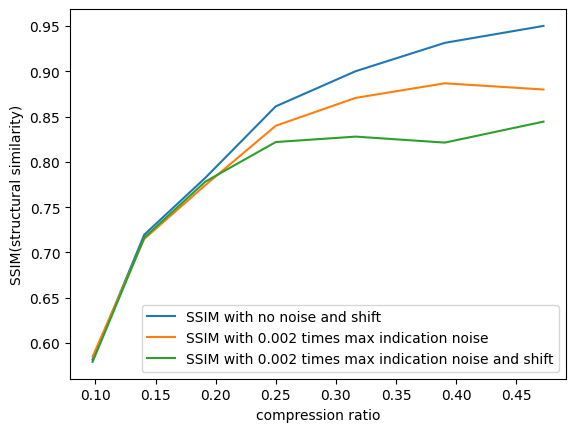

In [23]:
plt.plot(np.array(compressratio),ssims,label='SSIM with no noise and shift')
plt.plot(np.array(compressratio),ssims_1,label='SSIM with 0.002 times max indication noise')
plt.plot(np.array(compressratio),ssims_3,label='SSIM with 0.002 times max indication noise and shift')
plt.xlabel('compression ratio')
plt.legend()
plt.ylabel('SSIM(structural similarity)')
plt.savefig('C:/Users/DELL/Desktop/cheat/g.png',bbox_inches='tight',dpi=300)

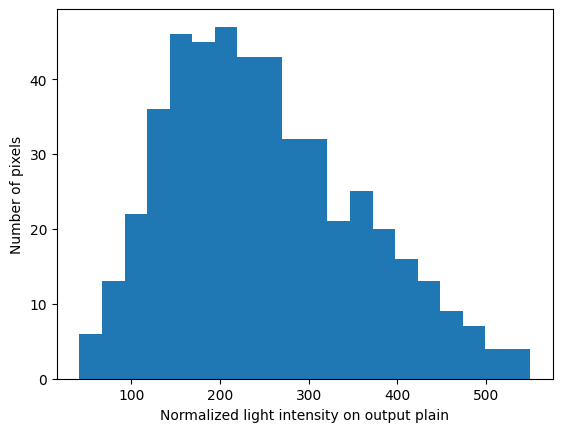

In [24]:
plt.hist(ccrop_vec,bins=20)
plt.xlabel('Normalized light intensity on output plain')
plt.ylabel('Number of pixels')
plt.savefig('C:/Users/DELL/Desktop/cheat/y.png',bbox_inches='tight',dpi=300)


# Part 6
### Different images' compression results at a fixed compression ratio=0.4

In [25]:
fashion_mnist=tf.keras.datasets.cifar10
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train1=x_train[:,:,:,0]

fashion_mnist=tf.keras.datasets.cifar100
(x_train2,y_train),(x_test,y_test)=fashion_mnist.load_data()
x_train2 = x_train2.astype('float32') / 255.
x_train2=x_train2[0:10,:,:,0]

fashion_mnist=tf.keras.datasets.mnist
(x_train3,y_train),(x_test,y_test)=fashion_mnist.load_data()
x_train3 = x_train3.astype('float32') / 255.
x_train3=x_train3[0:10,:,:]
x_train3=np.array([resize(x_train3[i],(32,32)) for i in range(len(x_train3))])

fashion_mnist=tf.keras.datasets.fashion_mnist
(x_train4,y_train),(x_test,y_test)=fashion_mnist.load_data()
x_train4 = x_train4.astype('float32') / 255.
x_train4=x_train4[0:10,:,:]
x_train4=np.array([resize(x_train4[i],(32,32)) for i in range(len(x_train4))])

In [26]:
l=12
pp=samplein(ker_mulchunk,croppedshape,16-l,16+l,16-l,16+l)
num=8
samples=np.zeros(shape=(num,32,32))
samples1=np.zeros(shape=(num,33,33))
samples[0:2]=x_train1[10:12]
samples[2:4]=x_train2[4:6]
samples[4:6]=x_train3[4:6]
samples[6:8]=x_train4[4:6]
for i in range(len(samples)):
    samples1[i]=resize(samples[i],(33,33))

TV iteration 10, the error is -2.8033131371785203e-14

TV iteration 20, the error is -2.7755575615628914e-16

TV iteration 30, the error is 8.004708007547379e-14

TV total iterations 32, the error is 8.3322237998118e-14 

TV iteration 10, the error is 1.9306778398231472e-13

TV iteration 20, the error is 1.2612133559741778e-13

TV iteration 30, the error is 1.7141843500212417e-13

TV total iterations 32, the error is 8.104628079763643e-14 

TV iteration 10, the error is -2.886579864025407e-15

TV iteration 20, the error is -1.9173551635276453e-13

TV iteration 30, the error is 3.108624468950438e-14

TV total iterations 31, the error is 1.3988810110276972e-14 

TV iteration 10, the error is 3.11972669919669e-14

TV iteration 20, the error is 9.880984919163893e-15

TV iteration 30, the error is 3.2651659154225854e-13

TV total iterations 31, the error is 1.212363542890671e-13 

TV iteration 10, the error is -5.040412531798211e-14

TV iteration 20, the error is 5.0182080713057076e-14

TV 

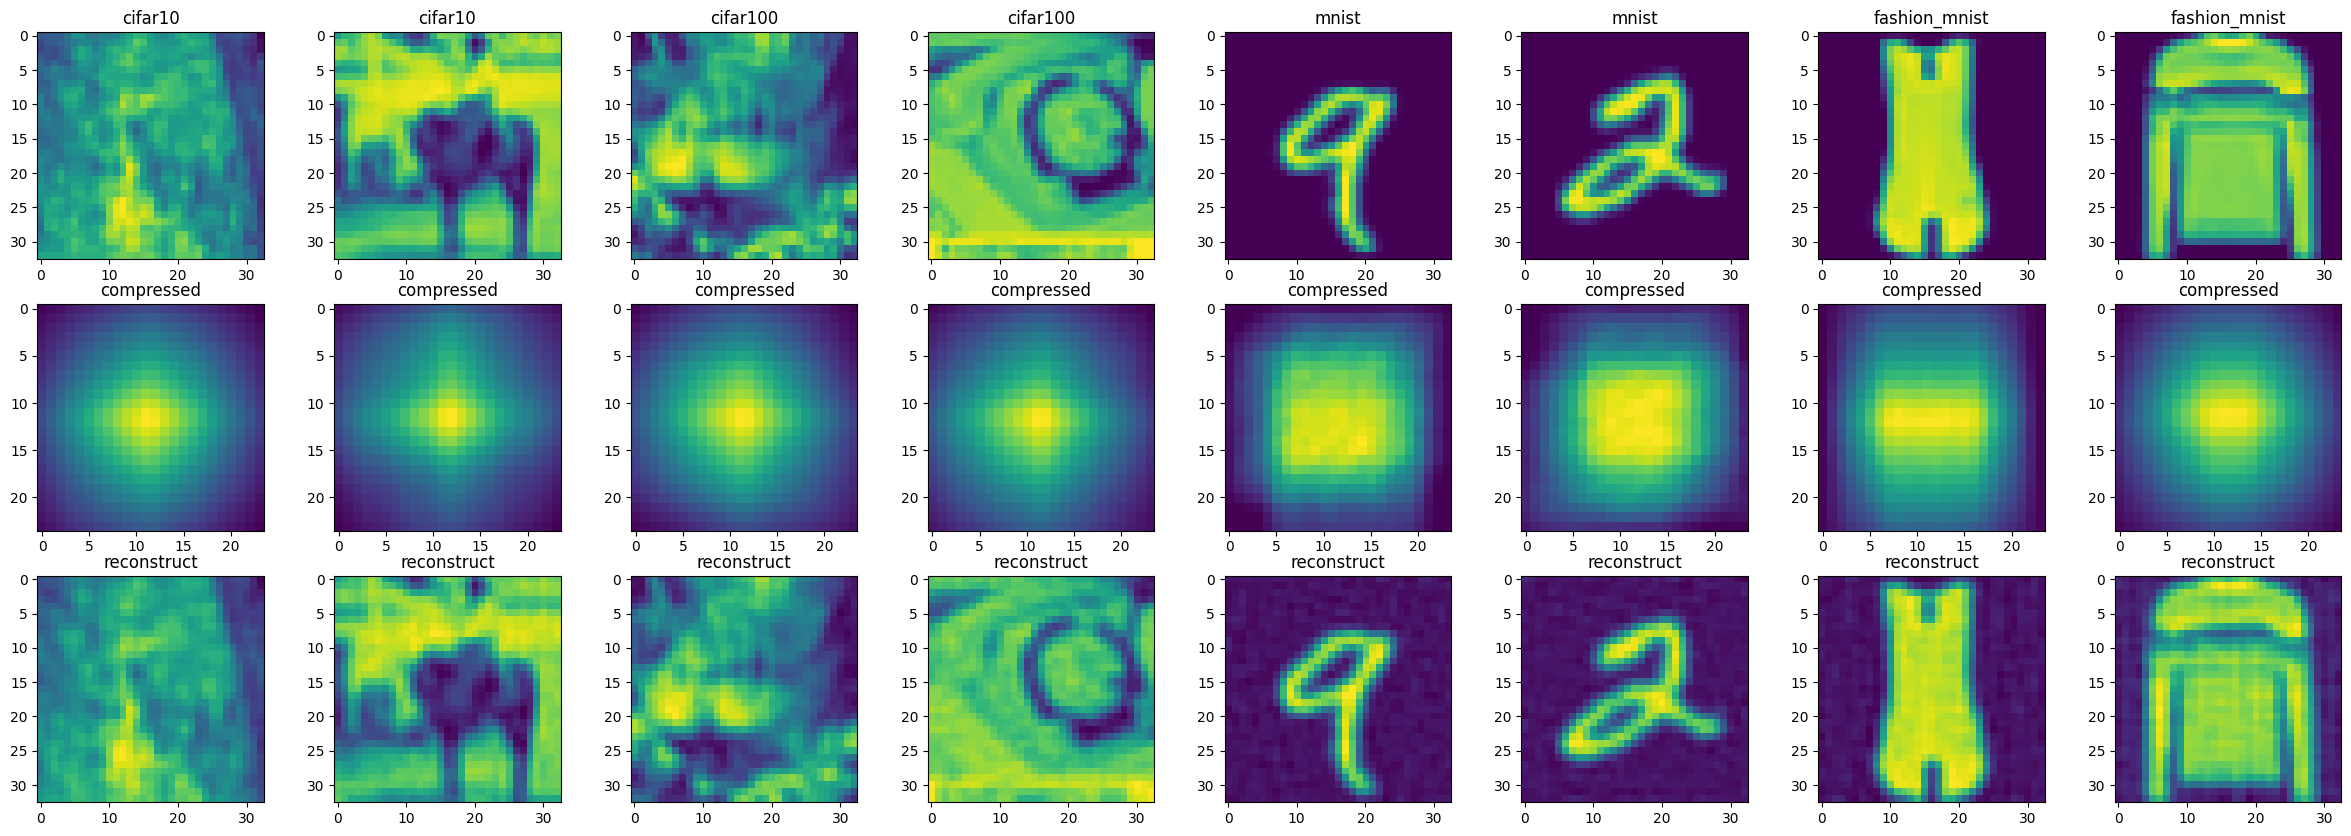

In [27]:

plt.figure(figsize=(30,10))
for i in range(num):
    tri=samples1[i]
    tri_vec=matrix_to_vector(tri)
    
    
    
    ccrop_vec=np.matmul(pp,tri_vec)
    ccrop=vector_to_matrix(ccrop_vec,(2*l,2*l))
    
    plt.subplot(3,num,i+1)
    plt.imshow(tri)
    
    if i>=0 and i<2:
        plt.title('cifar10')
    if i>=2 and i<4:
        plt.title('cifar100')
    if i>=4 and i<6:
        plt.title('mnist')
    if i>=6 and i<8:
        plt.title('fashion_mnist')
    #plt.colorbar()
    
    plt.subplot(3,num,i+1+num)
    plt.imshow(ccrop)
    plt.title('compressed')
    #plt.colorbar()

    
    im_vec=np.reshape(ccrop_vec,(-1,1))
    im_r_TV, totaliter = A_SPI_R_TV(pp,(33,33),im_vec);
    im_r_TV=np.reshape(im_r_TV,(-1))
    imag_r_TV=vector_to_matrix(im_r_TV,(33,33))
    
    plt.subplot(3,num,i+1+num*2)
    plt.imshow(imag_r_TV)
    plt.title('reconstruct')
#    ss=ssim(imag_r_TV,trialp)
#    ssims.append(ss)
    #plt.colorbar()
plt.savefig('C:/Users/DELL/Desktop/cheat/p.png',bbox_inches='tight',dpi=300)

# Appendix (not important)
### TV algo's ability demo

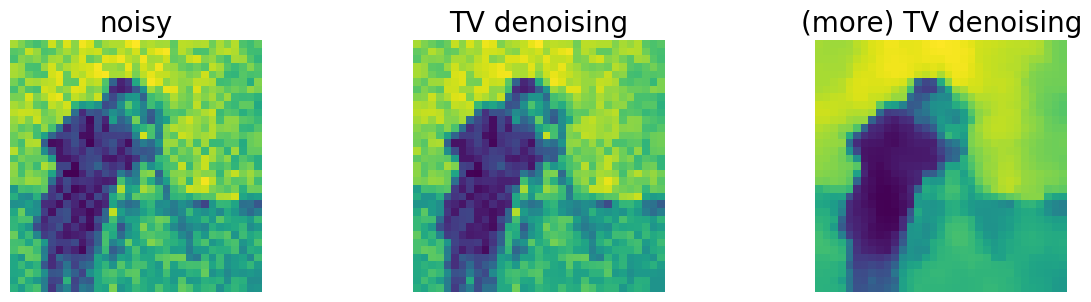

In [28]:

f=trialp
noisy = f + 1*f.std()*np.random.random(f.shape)

tv_denoised = denoise_tv_chambolle(noisy, weight=0.01)


plt.figure(figsize=(12, 2.8))

plt.subplot(131)
plt.imshow(noisy)
plt.axis('off')
plt.title('noisy', fontsize=20)
plt.subplot(132)
plt.imshow(tv_denoised)
plt.axis('off')
plt.title('TV denoising', fontsize=20)

tv_denoised = denoise_tv_chambolle(noisy, weight=0.09)
plt.subplot(133)
plt.imshow(tv_denoised)
plt.axis('off')
plt.title('(more) TV denoising', fontsize=20)

plt.subplots_adjust(wspace=0.02, hspace=0.02, top=0.9, bottom=0, left=0,
                    right=1)
plt.show()